## Оптимізація розрахунків
#### Завдання - зменшити час виконання програми чисельного інтегрування.
#### Для виконання завдання було вирішено переписати програму на іншій мові програмування, яка компілюється і дає змогу розпаралелювати обчислення.
#### Було вибрано мову програмування Go, адже є високорівневою та має високу швидкість виконання програм і простоту для запуску паралельних обчислень
#### Для перевірки швидкості виконання програми використовували модуль timeit для Python (результат в сек) та testing для Go (результат в нс)

In [237]:
import pandas as pd
import seaborn as sns
import scipy.stats as stats

In [238]:
# Функція для добування номера рядка з потрібною підстрічною в текстовому файлі
def OccurSubstring(List, searched):
    indices = [i for i, x in enumerate(List) if searched in x]
    return indices

In [239]:
# Парсимо результати go бенчмарку
with open("./go/go_res_bench", "r") as f:
    lines = f.readlines()

go_str = "BenchmarkSimpson-8" 
indicesGo = OccurSubstring(lines, go_str)
gor_str = "BenchmarkSimpsonGor-8" 
indicesGor = OccurSubstring(lines, gor_str)

go = []  # зберігаємо час виконання файлу го 
gor =[]  # час виконання фалу го з потоками
for line in range(len(lines)):
    if line in indicesGo:
        l = lines[line].strip().split()
        go.append(l[2])
    elif line in indicesGor:
        l = lines[line].strip().split()
        gor.append(l[2])


In [240]:
# Результати python бенчмарку
df = pd.read_csv("./python/py_res_bench.csv", nrows=len(go))
df["go"] = go
df["go_goroutine"] = gor
df["go_goroutine"] = df["go_goroutine"].astype(float)
df["go"] = df["go"].astype(float)

# переводимо з наносекунд в секунди
df['go'] = df.go.values / 1000000000
df['go_goroutine'] = df.go_goroutine.values / 1000000000

In [241]:
# Виводимо описову статистику
df.describe()

,python,go,go_goroutine
count,216.000000,216.000000,216.000000
mean,0.012066,0.000181,0.000174
std,0.000708,0.000015,0.000014
min,0.011193,0.000145,0.000134
25%,0.011479,0.000171,0.000165
50%,0.011744,0.000181,0.000173
75%,0.012598,0.000190,0.000181
max,0.015236,0.000243,0.000226


Text(0.5, 1.0, 'Runtime comparison')

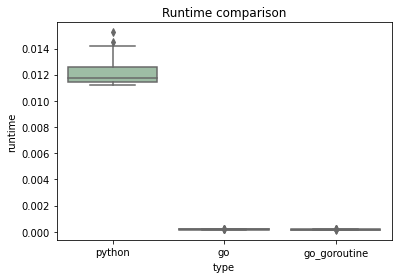

In [242]:
# Перетворюємо дані для зручногого формату тестів
df_melt = pd.melt(df.reset_index(), id_vars=['index'], value_vars=['python', 'go', 'go_goroutine'])
df_melt.columns = ['index', 'type', 'runtime']

ax = sns.boxplot(x='type', y='runtime', data=df_melt, color='#99c2a2')
ax.set_title("Runtime comparison")

### З графіку видно, що швидкість вмконання програми мовою Python набагато нижча, ніж Go

In [243]:
print("Go в середньому швидшие виконує програму за Пайтон в", df.python.mean()/df.go.mean(), "разів")
print("Go з використанням паралельних обчислень в середньому швидшие виконує програму за Пайтон в",df.python.mean()/df.go_goroutine.mean(),"разів")

Go в середньому швидшие виконує програму за Пайтон в 66.50230475692837 разів
Go з використанням паралельних обчислень в середньому швидшие виконує програму за Пайтон в 69.40474793767497 разів


### Доведемо статистичну різницю, використавши тест ANOVA

In [244]:
# Anova
stat, p = stats.f_oneway(df.python, df.go, df.go_goroutine)
print('Statistics=%.3f, p=%.10f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=60806.411, p=0.0000000000
Different distributions (reject H0)


###  Порівняємо код на Go 

Text(0.5, 1.0, 'Go vs Go with goroutines')

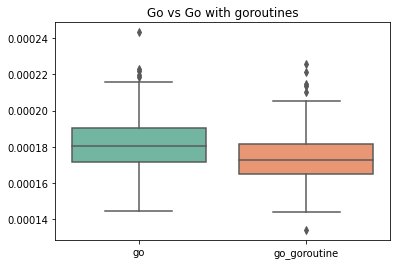

In [245]:
ax = sns.boxplot(data=df[['go','go_goroutine']], palette="Set2")
ax.set_title("Go vs Go with goroutines")

In [246]:
stat, p = stats.ttest_rel(df.go, df.go_goroutine)
print('Statistics=%.3f, p=%.10f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=5.525, p=0.0000000949
Different distributions (reject H0)


### На перший погляд різниці немає, але перевірка критерієм Стьюдента показала, що різниця у виконанні є значущою

In [247]:

print("Go з використанням паралельних обчислень в середньому швидшие виконує програму ніж Go без паралельних обчислень в", df.go.mean() / df.go_goroutine.mean(),"разів")

Go з використанням паралельних обчислень в середньому швидшие виконує програму ніж Go без паралельних обчислень в 1.0436442494941383 разів
